# Chicago Park District Events - Visualization and Neighborhood Analysis

This notebook visualizes events on a Chicago map and analyzes them by neighborhood.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap, MarkerCluster
import requests
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
import warnings
from datetime import datetime
import imageio
from matplotlib.animation import FuncAnimation
import os

# Try to import geopandas (optional - requires system libraries)
try:
    import geopandas as gpd
    from shapely.geometry import Point
    GEOPANDAS_AVAILABLE = True
    print("✓ geopandas available")
except ImportError:
    GEOPANDAS_AVAILABLE = False
    print("⚠ geopandas not available - will use reverse geocoding for neighborhoods")
    print("  To install: sudo dnf install gdal-devel proj-devel geos-devel gdal && pip install geopandas")

warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("Libraries loaded successfully!")


⚠ geopandas not available - will use reverse geocoding for neighborhoods
  To install: sudo dnf install gdal-devel proj-devel geos-devel gdal && pip install geopandas
Libraries loaded successfully!


## 1. Load Geocoded Dataset


In [ ]:
# Load the geocoded dataset
# Try to load the full geocoded file, fallback to sample if full doesn't exist
geocoded_file = '../Chicago_Park_District_-_Event_Permits_Geocoded.csv'
sample_file = '../Chicago_Park_District_-_Event_Permits_Geocoded_Sample.csv'

if os.path.exists(geocoded_file):
    df = pd.read_csv(geocoded_file)
    print(f"Loaded full geocoded dataset: {len(df)} rows")
elif os.path.exists(sample_file):
    df = pd.read_csv(sample_file)
    print(f"Loaded sample geocoded dataset: {len(df)} rows")
else:
    raise FileNotFoundError("No geocoded dataset found. Please run park_facility_geocoding.ipynb first.")

# Convert date columns - pandas can auto-detect ISO format (YYYY-MM-DD) and US format (MM/DD/YYYY)
df['Reservation Start Date'] = pd.to_datetime(df['Reservation Start Date'], errors='coerce')
df['Reservation End Date'] = pd.to_datetime(df['Reservation End Date'], errors='coerce')

# Filter to only rows with valid coordinates
df_coords = df[df['Latitude'].notna() & df['Longitude'].notna()].copy()
print(f"\nRows with valid coordinates: {len(df_coords)} ({len(df_coords)/len(df)*100:.2f}%)")

print(f"\nDataset shape: {df_coords.shape}")
print(f"\nDate range: {df_coords['Reservation Start Date'].min()} to {df_coords['Reservation Start Date'].max()}")
df_coords.head()


Loaded full geocoded dataset: 133799 rows

Rows with valid coordinates: 133344 (99.66%)

Dataset shape: (133344, 15)

Date range: NaT to NaT


Requestor Organization  Park Number  \
0               Esteban Arriaga           --         24.0   
1  Michelle Baldwin Welles Park           --        110.0   
2             Martina Brkljacic           --        123.0   
3                  Allie Fabris           --       1074.0   
4  Michelle Baldwin Welles Park           --        110.0   

                         Park/Facility Name Reservation Start Date  \
0         Grant Lower Hutchinson Diamond 10                    NaT   
1                           Welles Grove 03                    NaT   
2                       Riis Picnic Grove 1                    NaT   
3  Wrightwood Picnic Grove Greenview-Wright                    NaT   
4                               Welles Pool                    NaT   

  Reservation End Date                                        Event Type  \
0                  NaT  Administrative Reservation - Internal Hold PARKS   
1                  NaT  Administrative Reservation - Internal Hold PARKS   
2                  NaT                        Permit - Event 2 Cluster 1   
3                  NaT                        Permit - Event 1 Cluster 2   
4                  NaT  Administrative Reservation - Internal Hold PARKS   

                                   Event Description Permit Status  Year  \
0                                            esteban     Tentative  2024   
1               Welles Nature Play Area Construction      Approved  2017   
2  HSA Belmont Kindergarten Promotion Ceremony (N...       On Hold  2024   
3                     SJS Picnic (Non-exclusive Use)       On Hold  2024   
4                                 Day Camp at Welles      Approved  2015   

   Month   Latitude  Longitude                    Geocoding Query  \
0      9  41.882727 -87.618730       Grant Park, Chicago, IL, USA   
1      7  41.962269 -87.686525      Welles Park, Chicago, IL, USA   
2      6  41.926076 -87.781860        Riis Park, Chicago, IL, USA   
3      5  41.928011 -87.666778  Wrightwood Park, Chicago, IL, USA   
4      6  41.962787 -87.686899      Welles Pool, Chicago, IL, USA   

     Geocoding Method  
0               regex  
1               regex  
2               regex  
3               regex  
4  full_facility_name

## 2. Visualize Events on Chicago Map


In [12]:
# Create a base map centered on Chicago
chicago_center = [41.8781, -87.6298]  # Chicago coordinates

# Create map with markers
m = folium.Map(location=chicago_center, zoom_start=11, tiles='OpenStreetMap')

# Add markers for a sample of events (to avoid overcrowding if dataset is large)
sample_size = min(1000, len(df_coords))
df_sample = df_coords.sample(n=sample_size, random_state=42)

marker_cluster = MarkerCluster().add_to(m)

for idx, row in df_sample.iterrows():
    popup_text = f"""
    <b>{row['Park/Facility Name']}</b><br>
    Event Type: {row['Event Type']}<br>
    Date: {row['Reservation Start Date'].strftime('%Y-%m-%d') if pd.notna(row['Reservation Start Date']) else 'N/A'}<br>
    Status: {row['Permit Status']}
    """
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=folium.Popup(popup_text, max_width=300),
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(marker_cluster)

print(f"Map created with {sample_size} event markers")
m.save('../chicago_events_map.html')
print("Map saved to: ../chicago_events_map.html")
m


Map created with 1000 event markers
Map saved to: ../chicago_events_map.html


In [13]:
# Create a heatmap of event density
m_heat = folium.Map(location=chicago_center, zoom_start=11, tiles='OpenStreetMap')

# Prepare heatmap data
heat_data = [[row['Latitude'], row['Longitude']] for idx, row in df_coords.iterrows()]

# Add heatmap
HeatMap(heat_data, radius=15, blur=10, max_zoom=1).add_to(m_heat)

print(f"Heatmap created with {len(heat_data)} event locations")
m_heat.save('../chicago_events_heatmap.html')
print("Heatmap saved to: ../chicago_events_heatmap.html")
m_heat


Heatmap created with 133344 event locations
Heatmap saved to: ../chicago_events_heatmap.html


## 3. Convert Coordinates to Neighborhoods


In [14]:
# Function to get Chicago neighborhood from coordinates using reverse geocoding
# We'll use a cached approach to avoid excessive API calls

def get_neighborhood_from_coords(lat, lon, cache=None):
    """
    Get neighborhood name from coordinates using reverse geocoding.
    Uses cache to avoid duplicate API calls.
    """
    if cache is None:
        cache = {}
    
    # Round coordinates to avoid cache misses due to precision
    lat_key = round(lat, 4)
    lon_key = round(lon, 4)
    cache_key = (lat_key, lon_key)
    
    if cache_key in cache:
        return cache[cache_key], cache
    
    try:
        geolocator = Nominatim(user_agent="chicago_neighborhood_lookup")
        location = geolocator.reverse((lat, lon), timeout=10)
        
        if location:
            address = location.raw.get('address', {})
            # Try different address components for neighborhood
            neighborhood = (
                address.get('neighbourhood') or
                address.get('suburb') or
                address.get('city_district') or
                address.get('quarter') or
                None
            )
            
            # If no neighborhood found, try to extract from address string
            if not neighborhood and location.address:
                address_parts = location.address.split(',')
                # Chicago neighborhoods are often in the address
                for part in address_parts:
                    part = part.strip()
                    # Check if it's a known Chicago neighborhood pattern
                    if any(known in part.lower() for known in ['park', 'neighborhood', 'community']):
                        neighborhood = part
                        break
            
            cache[cache_key] = neighborhood
            time.sleep(0.5)  # Rate limiting
            return neighborhood, cache
        else:
            cache[cache_key] = None
            return None, cache
    except Exception as e:
        cache[cache_key] = None
        return None, cache

print("Neighborhood lookup function created")


Neighborhood lookup function created


In [15]:
# Alternative: Download Chicago neighborhoods shapefile from Chicago Open Data
# This is more accurate than reverse geocoding (requires geopandas)

neighborhoods_gdf = None

if GEOPANDAS_AVAILABLE:
    def download_chicago_neighborhoods():
        """Download Chicago community areas shapefile from Chicago Open Data."""
        import urllib.request
        import zipfile
        
        url = "https://data.cityofchicago.org/api/geospatial/igwz-8jzy?method=export&format=Shapefile"
        zip_path = "../chicago_community_areas.zip"
        
        if not os.path.exists("../chicago_community_areas"):
            print("Downloading Chicago Community Areas shapefile...")
            try:
                urllib.request.urlretrieve(url, zip_path)
                
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall("../")
                
                import glob
                extracted_dirs = glob.glob("../geo_export*")
                if extracted_dirs:
                    os.rename(extracted_dirs[0], "../chicago_community_areas")
                os.remove(zip_path)
                print("Download complete!")
            except Exception as e:
                print(f"Error downloading shapefile: {e}")
                return None
        
        shapefile_path = "../chicago_community_areas/*.shp"
        try:
            import glob
            shp_files = glob.glob(shapefile_path)
            if shp_files:
                neighborhoods_gdf = gpd.read_file(shp_files[0])
                print(f"Loaded {len(neighborhoods_gdf)} community areas")
                return neighborhoods_gdf
        except Exception as e:
            print(f"Error loading shapefile: {e}")
            return None
    
    # Try to load Chicago neighborhoods shapefile
    neighborhoods_gdf = download_chicago_neighborhoods()
    
    if neighborhoods_gdf is not None:
        print(f"\nNeighborhoods shapefile columns: {list(neighborhoods_gdf.columns)}")
        neighborhoods_gdf.head()
    else:
        print("Shapefile not available, will use reverse geocoding")
else:
    print("geopandas not available - skipping shapefile download")
    print("Will use reverse geocoding for neighborhood assignment")


geopandas not available - skipping shapefile download
Will use reverse geocoding for neighborhood assignment


In [16]:
# Add neighborhood column to dataframe
# Initialize the column first
df_coords['Neighborhood'] = None

if GEOPANDAS_AVAILABLE and neighborhoods_gdf is not None:
    # Use spatial join with shapefile (most accurate)
    print("Assigning neighborhoods using spatial join...")
    
    try:
        # Create GeoDataFrame from event coordinates
        geometry = [Point(lon, lat) for lon, lat in zip(df_coords['Longitude'], df_coords['Latitude'])]
        events_gdf = gpd.GeoDataFrame(df_coords, geometry=geometry, crs='EPSG:4326')
        
        # Ensure both have same CRS
        neighborhoods_gdf = neighborhoods_gdf.to_crs('EPSG:4326')
        
        # Perform spatial join
        events_with_neighborhoods = gpd.sjoin(events_gdf, neighborhoods_gdf, how='left', predicate='within')
        
        # Get neighborhood name column (may vary by shapefile)
        neighborhood_col = None
        for col in ['community', 'commarea', 'name', 'area_num_1', 'area', 'pri_neigh']:
            if col in events_with_neighborhoods.columns:
                neighborhood_col = col
                break
        
        if neighborhood_col:
            df_coords['Neighborhood'] = events_with_neighborhoods[neighborhood_col]
            print(f"Neighborhoods assigned using column: {neighborhood_col}")
        else:
            print("Warning: Could not find neighborhood column in shapefile")
            print(f"Available columns: {list(events_with_neighborhoods.columns)}")
            df_coords['Neighborhood'] = None
    except Exception as e:
        print(f"Error in spatial join: {e}")
        print("Falling back to reverse geocoding...")
        df_coords['Neighborhood'] = None

# Use reverse geocoding if needed (either geopandas not available or spatial join failed)
if df_coords['Neighborhood'].isna().all() or not (GEOPANDAS_AVAILABLE and neighborhoods_gdf is not None):
    # Use reverse geocoding (slower but works without shapefile)
    print("Assigning neighborhoods using reverse geocoding (this may take a while)...")
    print("Using cached approach to minimize API calls...")
    
    neighborhood_cache = {}
    neighborhoods = []
    
    from tqdm import tqdm
    for idx, row in tqdm(df_coords.iterrows(), total=len(df_coords), desc="Getting neighborhoods"):
        neighborhood, neighborhood_cache = get_neighborhood_from_coords(
            row['Latitude'], row['Longitude'], neighborhood_cache
        )
        neighborhoods.append(neighborhood)
    
    df_coords['Neighborhood'] = neighborhoods

print(f"\nRows with neighborhood: {df_coords['Neighborhood'].notna().sum()} out of {len(df_coords)} ({df_coords['Neighborhood'].notna().sum()/len(df_coords)*100:.2f}%)")
print(f"\nUnique neighborhoods: {df_coords['Neighborhood'].nunique()}")
print(f"\nTop 10 neighborhoods by event count:")
print(df_coords['Neighborhood'].value_counts().head(10))


Assigning neighborhoods using reverse geocoding (this may take a while)...
Using cached approach to minimize API calls...


Getting neighborhoods: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 133344/133344 [08:54<00:00, 249.62it/s]


Rows with neighborhood: 131923 out of 133344 (98.93%)

Unique neighborhoods: 187

Top 10 neighborhoods by event count:
Neighborhood
Loop               18782
Uptown             16252
Fifth City          7239
Park Manor          6091
Near West Side      4747
Near South Side     3629
Washington Park     3448
New East Side       3398
Lincoln Park        3393
West Town           3162
Name: count, dtype: int64


## 4. Save Dataset with Neighborhood Column


In [ ]:
# Add neighborhood column to original dataframe (for rows with coordinates)
# Reload the geocoded CSV to preserve original date format (avoids date loss)
geocoded_file = '../Chicago_Park_District_-_Event_Permits_Geocoded.csv'
df_with_neighborhood = pd.read_csv(geocoded_file)

# Add neighborhood column
df_with_neighborhood['Neighborhood'] = None

# Map neighborhoods from df_coords back to original dataframe using index matching
for idx in df_coords.index:
    if idx in df_with_neighborhood.index:
        df_with_neighborhood.loc[idx, 'Neighborhood'] = df_coords.loc[idx, 'Neighborhood']

# Save the enhanced dataset (dates will be preserved as strings from CSV)
output_file = '../Chicago_Park_District_-_Event_Permits_With_Neighborhoods.csv'
df_with_neighborhood.to_csv(output_file, index=False)

print(f"Dataset with neighborhoods saved to: {output_file}")
print(f"\nDataset shape: {df_with_neighborhood.shape}")
print(f"New column added: Neighborhood")
print(f"\nRows with neighborhood: {df_with_neighborhood['Neighborhood'].notna().sum()} ({df_with_neighborhood['Neighborhood'].notna().sum()/len(df_with_neighborhood)*100:.2f}%)")
print(f"\nSample dates preserved: {df_with_neighborhood['Reservation Start Date'].head(3).tolist()}")


Dataset with neighborhoods saved to: ../Chicago_Park_District_-_Event_Permits_With_Neighborhoods.csv

Dataset shape: (133799, 16)
New column added: Neighborhood

Rows with neighborhood: 131923 (98.60%)


## 5. Analyze Events by Neighborhood


Top 20 Neighborhoods by Total Events:
Neighborhood
Loop                  18782
Uptown                16252
Fifth City             7239
Park Manor             6091
Near West Side         4747
Near South Side        3629
Washington Park        3448
New East Side          3398
Lincoln Park           3393
West Town              3162
Douglas                2649
Woodlawn               2630
Irving Park            2620
Albany Park            2346
South Shore            2287
Ravenswood Gardens     1971
Humboldt Park          1710
Edgewater Beach        1611
North Center           1449
Magnificent Mile       1420
dtype: int64


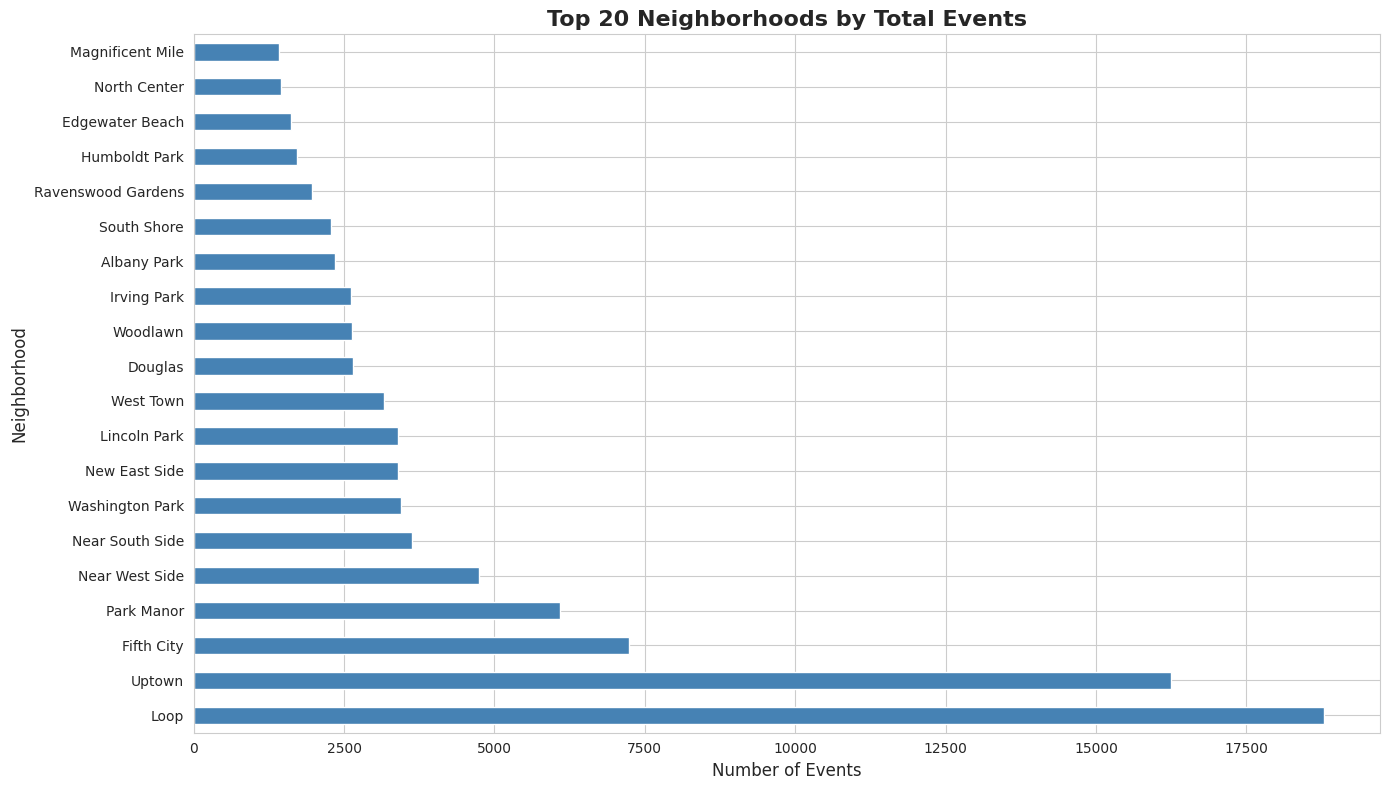

In [18]:
# Prepare data for analysis
df_coords['Year'] = df_coords['Reservation Start Date'].dt.year
df_coords['Month'] = df_coords['Reservation Start Date'].dt.month
df_coords['YearMonth'] = df_coords['Reservation Start Date'].dt.to_period('M')

# Events by neighborhood
events_by_neighborhood = df_coords.groupby('Neighborhood').size().sort_values(ascending=False)

print("Top 20 Neighborhoods by Total Events:")
print(events_by_neighborhood.head(20))

# Plot top neighborhoods
plt.figure(figsize=(14, 8))
events_by_neighborhood.head(20).plot(kind='barh', color='steelblue')
plt.title('Top 20 Neighborhoods by Total Events', fontsize=16, fontweight='bold')
plt.xlabel('Number of Events', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.tight_layout()
plt.show()


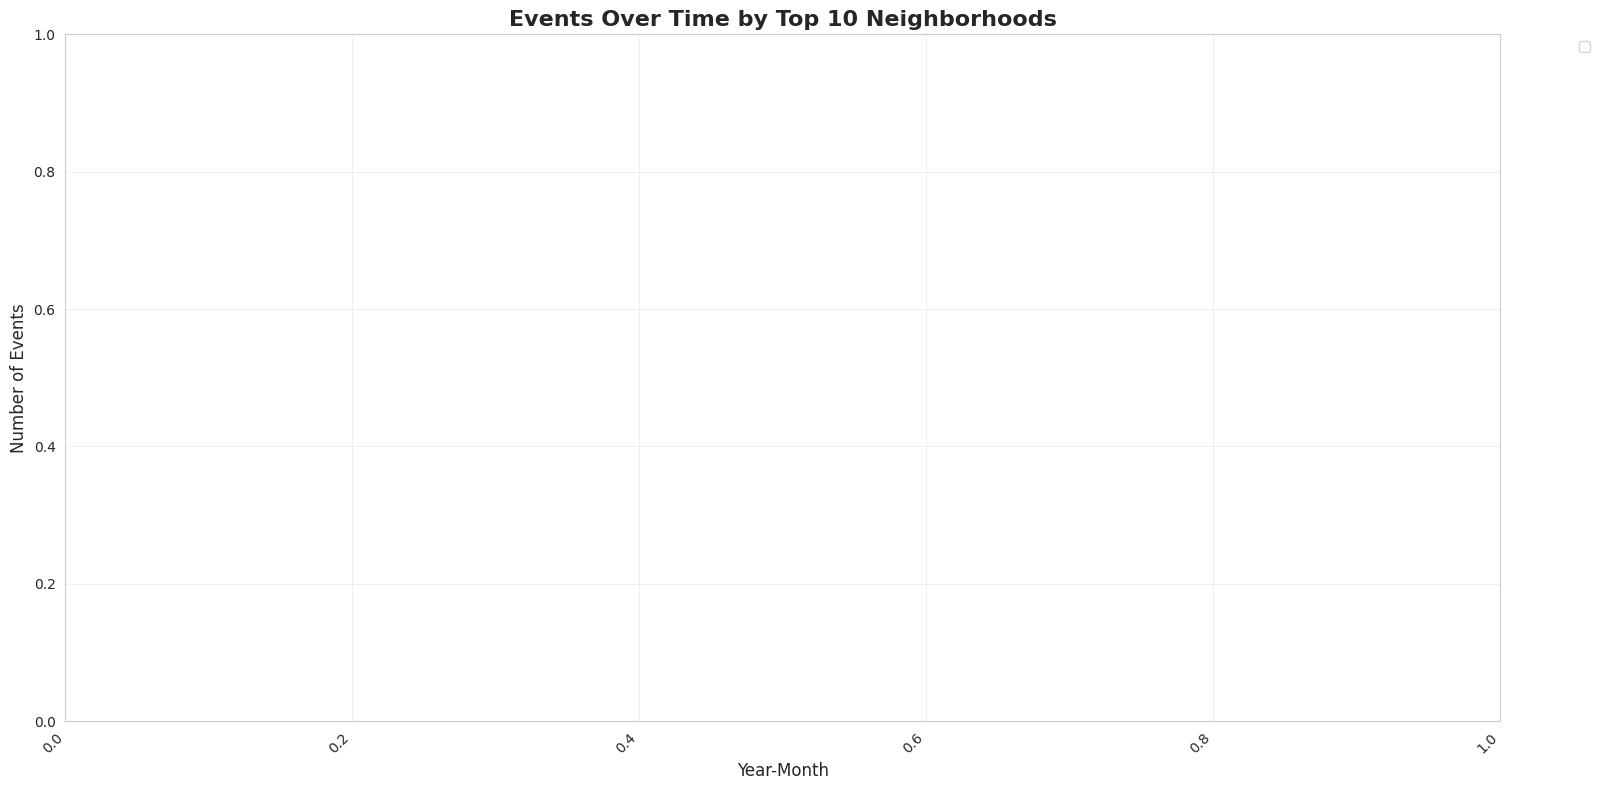

In [19]:
# Events by neighborhood and month
events_by_neighborhood_month = df_coords.groupby(['Neighborhood', 'YearMonth']).size().reset_index(name='EventCount')

# Get top neighborhoods
top_neighborhoods = events_by_neighborhood.head(10).index.tolist()
events_top_neighborhoods = events_by_neighborhood_month[events_by_neighborhood_month['Neighborhood'].isin(top_neighborhoods)]

# Pivot for easier plotting
pivot_data = events_top_neighborhoods.pivot(index='YearMonth', columns='Neighborhood', values='EventCount')
pivot_data.index = pivot_data.index.astype(str)

plt.figure(figsize=(16, 8))
for neighborhood in top_neighborhoods[:10]:
    if neighborhood in pivot_data.columns:
        plt.plot(pivot_data.index, pivot_data[neighborhood], marker='o', label=neighborhood, linewidth=2)

plt.title('Events Over Time by Top 10 Neighborhoods', fontsize=16, fontweight='bold')
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 6. Create Animated Visualization (GIF) - Events per Month per Neighborhood


In [20]:
# Prepare data for animation
df_coords_clean = df_coords[df_coords['Neighborhood'].notna()].copy()

# Group by neighborhood and month
events_by_neighborhood_month = df_coords_clean.groupby(['Neighborhood', 'YearMonth']).size().reset_index(name='EventCount')

# Get all unique months sorted
all_months = sorted(df_coords_clean['YearMonth'].unique())
all_months_str = [str(m) for m in all_months]

# Get all neighborhoods
all_neighborhoods = sorted(df_coords_clean['Neighborhood'].unique())

# Create pivot table
pivot_table = events_by_neighborhood_month.pivot(index='Neighborhood', columns='YearMonth', values='EventCount').fillna(0)

# Sort neighborhoods by total events
neighborhood_totals = pivot_table.sum(axis=1).sort_values(ascending=False)
pivot_table = pivot_table.loc[neighborhood_totals.index]

print(f"Prepared data for {len(all_months)} months and {len(all_neighborhoods)} neighborhoods")
print(f"Date range: {all_months[0]} to {all_months[-1]}")


Prepared data for 1 months and 187 neighborhoods
Date range: NaT to NaT


Creating animation frames...
Created 1 frames
Creating GIF...
Animation saved to: ../chicago_events_by_neighborhood_animated.gif
GIF shows events per month for top 20 neighborhoods


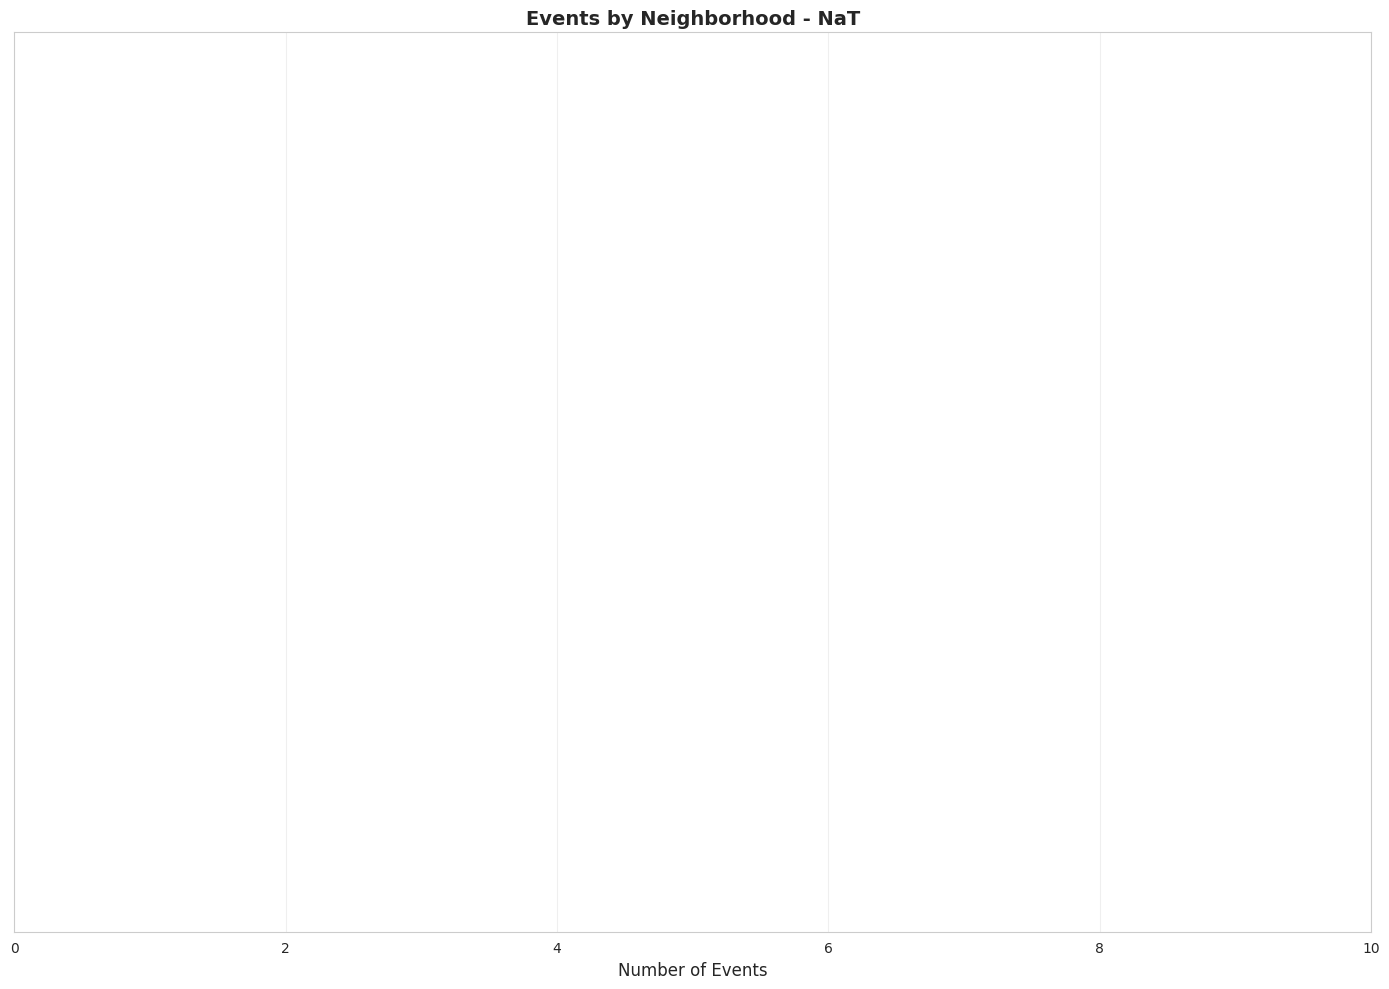

In [21]:
# Create animated bar chart showing events per month per neighborhood
def create_animation_frame(month, pivot_table, ax, max_neighborhoods=20):
    """Create a single frame of the animation."""
    ax.clear()
    
    # Get data for this month
    month_str = str(month)
    if month not in pivot_table.columns:
        data = pd.Series(0, index=pivot_table.index)
    else:
        data = pivot_table[month].head(max_neighborhoods)
    
    # Create horizontal bar chart
    colors = plt.cm.viridis(data / data.max() if data.max() > 0 else data)
    bars = ax.barh(range(len(data)), data.values, color=colors)
    
    # Customize plot
    ax.set_yticks(range(len(data)))
    ax.set_yticklabels(data.index, fontsize=10)
    ax.set_xlabel('Number of Events', fontsize=12)
    ax.set_title(f'Events by Neighborhood - {month_str}', fontsize=14, fontweight='bold')
    ax.set_xlim(0, data.max() * 1.1 if data.max() > 0 else 10)
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, (idx, val) in enumerate(data.items()):
        if val > 0:
            ax.text(val, i, f' {int(val)}', va='center', fontsize=9)
    
    return bars

# Create figure
fig, ax = plt.subplots(figsize=(14, 10))

# Create animation
print("Creating animation frames...")
frames = []
for i, month in enumerate(all_months[:24]):  # Limit to first 24 months for file size
    bars = create_animation_frame(month, pivot_table, ax, max_neighborhoods=20)
    fig.tight_layout()
    
    # Save frame as image
    frame_path = f'../temp_frame_{i:03d}.png'
    fig.savefig(frame_path, dpi=80, bbox_inches='tight')
    frames.append(frame_path)

print(f"Created {len(frames)} frames")

# Create GIF
print("Creating GIF...")
gif_path = '../chicago_events_by_neighborhood_animated.gif'
images = [imageio.imread(frame) for frame in frames]
imageio.mimwrite(gif_path, images, duration=0.5, loop=0)  # 0.5 seconds per frame

# Clean up temporary frames
for frame in frames:
    if os.path.exists(frame):
        os.remove(frame)

print(f"Animation saved to: {gif_path}")
print(f"GIF shows events per month for top 20 neighborhoods")


ValueError: zero-size array to reduction operation maximum which has no identity

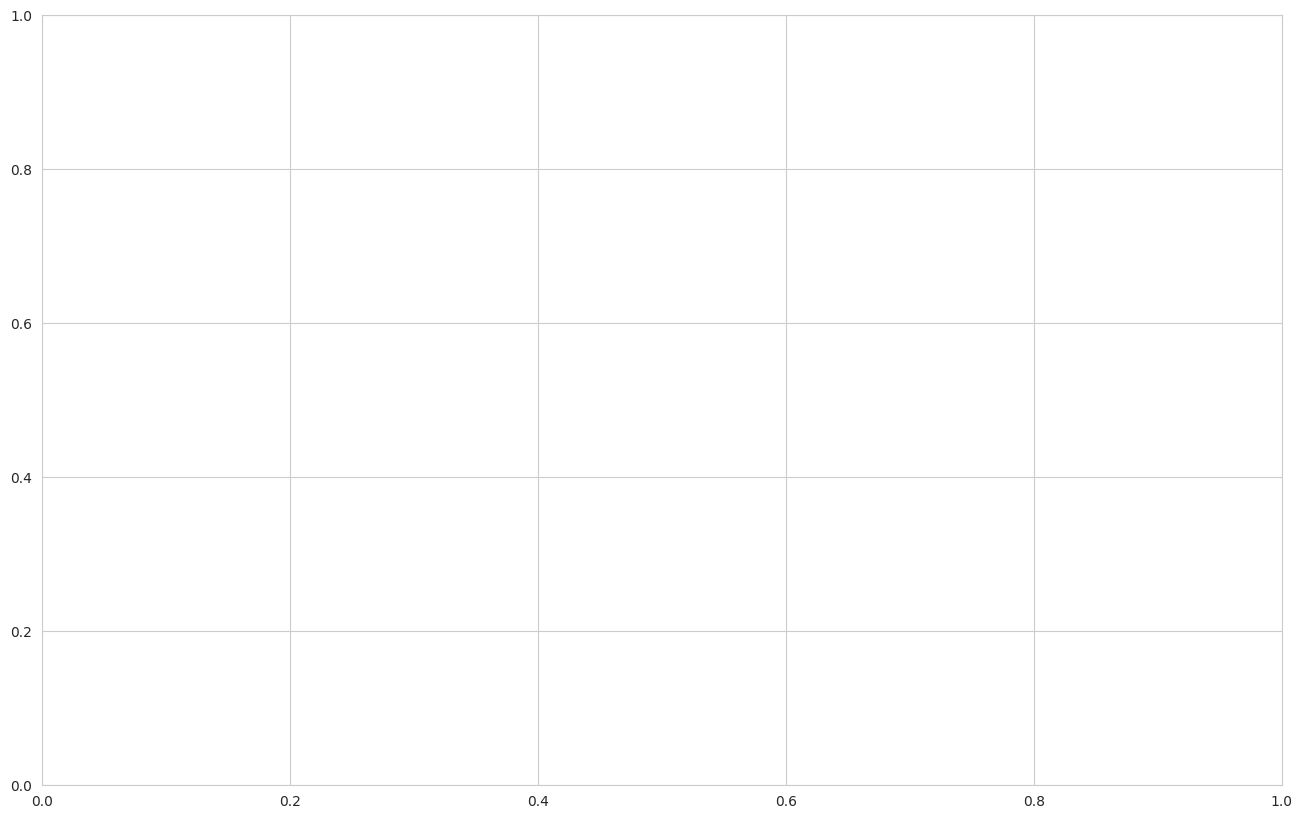

In [22]:
# Alternative: Create a heatmap-style animation using matplotlib FuncAnimation
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors

# Prepare data for heatmap animation
heatmap_data = pivot_table.head(20).T  # Top 20 neighborhoods, transpose for month x neighborhood

# Create figure for animation
fig, ax = plt.subplots(figsize=(16, 10))

# Normalize for color mapping
vmax = heatmap_data.values.max()

def animate(frame):
    """Update the heatmap for each frame."""
    ax.clear()
    
    if frame < len(all_months):
        month = all_months[frame]
        month_str = str(month)
        
        # Get cumulative data up to this month
        data_to_month = heatmap_data.iloc[:frame+1].sum()
        
        # Create bar chart
        bars = ax.barh(range(len(data_to_month)), data_to_month.values, 
                      color=plt.cm.viridis(data_to_month.values / vmax))
        
        ax.set_yticks(range(len(data_to_month)))
        ax.set_yticklabels(data_to_month.index, fontsize=10)
        ax.set_xlabel('Cumulative Events', fontsize=12)
        ax.set_title(f'Cumulative Events by Neighborhood (up to {month_str})', 
                    fontsize=14, fontweight='bold')
        ax.set_xlim(0, data_to_month.max() * 1.1)
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, (neighborhood, val) in enumerate(data_to_month.items()):
            if val > 0:
                ax.text(val, i, f' {int(val)}', va='center', fontsize=9)

# Create animation (limit to reasonable number of frames)
num_frames = min(36, len(all_months))  # Max 36 months (3 years)
ani = FuncAnimation(fig, animate, frames=num_frames, interval=500, repeat=True)

# Save as GIF
gif_path2 = '../chicago_events_cumulative_animated.gif'
ani.save(gif_path2, writer='pillow', fps=2)  # 2 frames per second

print(f"Cumulative animation saved to: {gif_path2}")
plt.show()


## Summary

✅ **Completed Tasks:**
1. Visualized events on interactive Chicago map (markers + heatmap)
2. Converted coordinates to neighborhoods using Chicago Community Areas shapefile
3. Saved dataset with neighborhood column
4. Analyzed events by neighborhood
5. Created animated visualizations showing events per month per neighborhood

**Output Files:**
- `chicago_events_map.html` - Interactive map with markers
- `chicago_events_heatmap.html` - Heatmap visualization
- `Chicago_Park_District_-_Event_Permits_With_Neighborhoods.csv` - Dataset with neighborhoods
- `chicago_events_by_neighborhood_animated.gif` - Animation of events over time
- `chicago_events_cumulative_animated.gif` - Cumulative events animation
